#COMPSCI 546: Applied Information Retrieval
##Assignment 2: Text Processing and Indexing (Total : 100 points)



# Download input files

Please execute the cell below to download the input files. 

In [ ]:

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


import os
import zipfile

download = drive.CreateFile({'id': '1YoRCcM8bt3Dy9mgsCwYoy9EpWQzGjOyj'})
download.GetContentFile('HW02.zip')

with zipfile.ZipFile('HW02.zip', 'r') as zip_file:
    zip_file.extractall('./')
os.remove('HW02.zip')
# We will use hw1 as our working directory
os.chdir('HW02')

#Setting the input file
col = "antique-collection.tok.clean_kstem"

In [ ]:
import pandas as pd
pid = []
intpid = []
passage = []
i = 1
docMap = {}
with open(col) as f:
  for line in f:
    temp = line.rstrip().split("\t")
    pid.append(temp[0])
    passage.append(temp[1])
    intpid.append(i)
    docMap[i] = temp[0]
    i += 1
     

pid_struct = pd.DataFrame({'intPid': intpid, 'Passage_id': pid, 'passage': passage})



# 1 : Inverted Index Construction (40 points)
We use the collection from the ANTIQUE  [https://arxiv.org/pdf/1905.08957.pdf] dataset for this assignment. As described in the previous assignment, this is a passage retrieval dataset and the collection consists of passages. Each row of the file consists of the following information:

*passage_id  passage_text*

The passage_id and passage_text information is tab ('\t') separated. The passage text has been pre-processed to remove punctutation, tokenised and stemmed using the Krovetz stemmer. The terms in the passage text can be accessed by splitting the text based on space. 





Question 1.1 (15 points)

In the cell below, you have to implement the following:

1) Create new integer passage ids ranging from [1-num of passages in the collection], corresponding to each passageId given in the input collection file, for eg: the passageId in the first row would correspond to 1, the one on the second row would correspond to 2 and so on. Please store this in a data structure which could be accessed in subsequent cells. Please note that the collection could contain passageIds with no corresponding text information. While reading the collection file, you may need to handle this scenario.

2) An inverted index with count information. An example is given in Section 5.3.2 of the reference book : "Search Engines: Information Retrieval in Practice". A typical entry (posting) in this type of inverted index would consist of a term followed by the set of passages in which it occurs along with number of times it occured within each of them. For eg: if a term "fish" occured in two passages with ids: "4" and "10" and corresponding frequencies "1" and "2", the entry for "fish" would look like this.

*fish  4:1 10:2*

Please note that the passage ids within the index must correspond to the newly created passage ids. For a particular term, the passage ids must be sorted in ascending order (small->large), like the example given above (where "4" is less than "10"). 

Besides the term count information, the index must also contain the statistics such as total number of tokens in the collections and total number of unique terms.

Real-world indices are typically very large and cannot be stored in memory, however the collection provided for this assignment is fairly small and can be easily loaded into memory.


In [ ]:
''' 
In this function, create inverted index with count information  
Return Variables: 
indexCount - Datastructure used for holding the inverted index with count information. 
             Please note that besides the term posting list, you must also store information 
             such as total number of tokens in the collections, total number of unique terms
             and total number of unique passages in the collection (This would also include any 
               potential passagIds with empty text).
numPassages - Total number of unique passages in the collection. 
              You can return the count stored within the index.
docMap -  datastructure which maps newly created passage ids to original passage ids. 
          ie eg: 1 ->"2020338_0", 2->"2020338_1"               
'''

def createIndexCount(col):
    #enter your code here

    postingList = {}
    totalTerms = 0
    for index, rows in pid_struct.iterrows():
      intpid = index + 1
      p = rows['passage'].split(" ")
      for i in p:
        if i not in postingList:
          postingList[i] = { 'termstat' : {'df' : 1, 'ctf' : 1}, 'postlist': {intpid : 1} }
          totalTerms += 1
        else: 
          keyval = postingList[i]
          keyval['termstat']['ctf'] += 1
          totalTerms += 1
          if intpid in keyval['postlist']:
            keyval['postlist'][intpid] += 1
          else:
            keyval['termstat']['df'] += 1
            keyval['postlist'][intpid] = 1
    uniqTerms = len(postingList)
    numPassages = pid_struct['intPid'].iloc[-1]
    indexCount = {'totalTerms': totalTerms, 'uniqTerms': uniqTerms, 'numPassages': numPassages, 'Terms': postingList}    
    return indexCount, numPassages, docMap

''' this is an example. You can return additional information based on your implementation.'''

indexCount, numPassages, docMap = createIndexCount(col) 

#sanity check
print ('Total number of passages in the collection :{0}'.format(numPassages))
   

Total number of passages in the collection :403492


Question 1.2 (10 points)

Please give a short description of your implementation of the index including how the postings are stored within the index.  

**Enter your answer here!**

In my implementation of inverted index, the data structure that is used to store the posting list and term statistics is a dictionary. 

First, in pid_struct the mapping of each passage_id to its integer equivalent passage id is done. Along with integer passage id, the passage is also stored in the data frames corresponding to each passage_id. 

Then, a 'postingList' dictionary is created wherein, on iterating over each value of passage id, the corresponding passage is read. Then, the passage is split based on empty space and then each word obtained after the split is added as a key to the 'postingList' dictionary. The corresponding value for this term key is another dictionary containing the term statistics parameters. This value dictionary consists of two keys - 'termstat' and 'postlist'. 'termstat' consists of key value pairs for 'df' - document frequency and 'ctf' - collection term frequency. 'df' corresponds to the number of passages in which this term was found and 'ctf' corresponds to the total number of occurrences of that term in the whole collection across all passages. In 'postList', key value pairs of the integer passage id and the number of times the term was found in the corresponding passage is stored as the value. Here, they are stored in an orderly sorted order with the passage ids in an ascending order. The condition for empty passages is also taken care of here, as no new term will be added. 

Here, I am using a double for loop. The outer for loop is to loop over passages and the inner for loop is to loop over all the terms in each passage after they are split. So, if a new term which is not present in the 'postingList' dictionary is found in the passage, then a new entry is created in the dictionary. Else, if it already exists in the dictionary then, the count of the term is increased and the corresponding passage id is entered in the dictionary structure. 

Finally, once all the passages have been parsed, the term statistics are calculated. The 'uniqTerms' gives the number of unique terms that are present in the whole collection. It is basically the length of the 'postingList' dictionary as it contains all the unique terms as keys. 'numPassages' is the length of the passage ids which are all unique, as all the passages are unique themselves. 'totalTerms' is the summation of the 'ctf' value for each of the terms, that is calculated while looping over each term in the passage. These term stats are then added as key value pairs in the inverted index dictionary called 'indexCount'.

'docMap' consists of a dictionary with the key as the integer passage id and the value to be the original passage id.

Question 1.3 (10 points)

In the cell below, you have to implement an index with delta encoding. Please note that delta encoding is done only for passage ids and not for term count information. Instead of reading through the entire collection file again, you can use the index created above to generate the new index.

In [ ]:
''' 
In this function, create inverted index with count information and delta encoded passage ids.  
Return Variables: 
indexDelta - Datastructure used for holding the new inverted index with count information.
             Please note that you must also store information such as total number of tokens, 
             total number of unique terms and total number of unique passages in the collection.
             (This would also include any potential passagIds with empty text)
numPassages - Total number of unique passages in the collection. 
              You can return the count stored within the index. 
'''

import copy

def createIndexDeltaCount(indexCount):
    #enter your code here
    indexDelta = copy.deepcopy(indexCount)
    terms = indexDelta['Terms']
    for key in terms:
      termval = key
      postList = terms[key]['postlist']
      start = 0
      postArr = []
      for key1, val1 in postList.items():
        new_key = key1 - start
        start = key1
        postArr.append((new_key, val1))
      indexDelta['Terms'][key]['postlist'] = postArr

    numPassages = pid_struct['intPid'].iloc[-1] 

    return indexDelta, numPassages

''' this is an example. You can return additional information based on your implementation.'''
indexDelta, numPassages = createIndexDeltaCount(indexCount) 

#sanity check
print ('Total number of passages in the collection :{0}'.format(numPassages))

Total number of passages in the collection :403492


Question 1.4 (5 points)

Please give a short description of delta encoding.

**Enter your answer here!**

The motive behind delta encoding is that those terms that occur very frequently in a lot of passages will have to store the entire passage ids for each passage in which they are found. This is going to take up a lot of space, especially when the terms are found in consecutive passages, it is like storing the same passage ids that are a byte long with only a differnce in one of the byte. 

So, instead of storing the whole passage id in the postingList, it is more effective to store the difference of the passage ids in the postingList. For example - the term 'school' occurs in the passage ids - 1000, 1001, 1002, 1005, 1009, 1020. It is going to be a lot of redundant information if we store each of the passage ids. It is also going to take up a lot more memory. That's why in delta encoding, the difference of the values of the passage ids are taken and stored. So, in the delta encoding postingList, the values stored will be - 1000, 1, 1, 3, 4, 11. Thus, only smaller values of the passage ids are to be stored. Given that while accessing a posting list, it is done only in a sequential manner, it is easy to decode this delta encoded passage ids, by just summing up the values up until before the target rank. 

Delta encoding is very useful especillay for high frequency terms. But for those terms that occur less frequently, the passage ids (long or short) have to be stored. 

# 2 : Accessing Index Information (30 points) 



In the cell below, implement functions which would take an index and term as input and access the passage id and count information. For the delta encoded version, you have to decode the delta encoding. 


In [ ]:
''' 
In this function, access the inverted index with count information and return passage id
and and count information. 
Return Variables: 
termFreqIndexCount - Number of passages containing input term "term" 
passageListCount -  First 5 passageIds(original passage ids) in the postings list.
                    To return original passage ids, you can use docMap. 
'''
def accessTermInfoIndex(term, indexCount, docMap):
  #enter your code here
  #term is to be accessed
  termFreqIndexCount = indexCount['Terms'][term]['termstat']['df']

  #top 5 passage IDs for term
  k = 5
  pids = indexCount['Terms'][term]['postlist']
  topPid = dict(list(pids.items())[0: k]) 
  passageListCount = []
  for key in topPid.keys():
    passageListCount.append(docMap[key])
  return termFreqIndexCount, passageListCount     

''' 
In this function, access the inverted index with count information and delta encoded passage ids 
and return passage ids and count information. 
Return Variables: 
termFreqIndexCount - Number of passages containing input term "term" 
passageListCount -  First 5 passageIds(original passage ids) in the postings list for the input "term". 
                    You have to decode the delta encoding and then map to original ids using docMap.    
'''
def accessTermInfoIndexDelta(term, indexDelta, docMap):
  #enter your code here
  #term is to be accessed
  termFreqIndexDelta = indexDelta['Terms'][term]['termstat']['df']

  #top 5 passage IDs for term
  k = 5
  pids = indexDelta['Terms'][term]['postlist']
  topPid = pids[:k]
  passageListDelta = []
  start = 0
  for tup in topPid:
    pid = start + tup[0]
    passageListDelta.append(docMap[pid])
    start = pid

  return termFreqIndexDelta, passageListDelta 


termFreqIndexCount, passageListCount  = accessTermInfoIndex("computer",indexCount,docMap)
termFreqIndexDelta, passageListDelta   = accessTermInfoIndexDelta("computer",indexDelta,docMap)

# check output for a term. Please make that the final pdf displays all the outputs.
print ("Index term information")
print ('Total number of Passages containing the term "computer" :{0}'.format(termFreqIndexCount))
print ('First 5 passages with the term "computer" :{0}'.format(passageListCount))
print ("**************************************************************************************")
print ("Index term information with delta encoding")
print ('Total number of Passages containing the term "computer" :{0}'.format(termFreqIndexDelta))
print ('First 5 passages with the term "computer" :{0}'.format(passageListDelta))


Index term information
Total number of Passages containing the term "computer" :2718
First 5 passages with the term "computer" :['629558_0', '1528314_0', '3384343_0', '1873488_1', '2084699_0']
**************************************************************************************
Index term information with delta encoding
Total number of Passages containing the term "computer" :2718
First 5 passages with the term "computer" :['629558_0', '1528314_0', '3384343_0', '1873488_1', '2084699_0']


# 3 : Display Index Statistics (10 points)


In the cell below, please create APIs to access various statistics from the index. 

In [ ]:
''' 
In this function, access the inverted index with count information and return term statistics
Return Variables: 
totNumTerms - Total number of tokens in the collection stored in the index
totNumUniqueTerms -  Total number of unique terms stored in the index 
'''

def displayIndexStats(indexCount):
    #enter your code here
    totNumTerms = indexCount['totalTerms']
    totNumUniqueTerms = indexCount['uniqTerms']

    return totNumTerms, totNumUniqueTerms

''' 
In this function, access the inverted index with count information and delta encoded passagesIds 
and return term statistics
Return Variables: 
totNumTerms - Total number of tokens in the collection stored in the index
totNumUniqueTerms -  Total number of unique terms stored in the index 
'''
def displayIndexDeltaStats(indexDelta):
    #enter your code here
    totNumTerms = indexDelta['totalTerms']
    totNumUniqueTerms = indexDelta['uniqTerms']

    return totNumTerms, totNumUniqueTerms

totNumTermsIndexCount, totNumUniqueTermsIndexCount = displayIndexStats(indexCount)
totNumTermsIndexDelta, totNumUniqueTermsIndexDelta = displayIndexDeltaStats(indexDelta)

#printing the output
print ("Index Statistics from IndexCount")
print ('Total number of Unique Terms :{0}'.format(totNumUniqueTermsIndexCount))
print ('Total number of tokens :{0}'.format(totNumTermsIndexCount))
print ("**************************************************************************************")
print ("Index Statistics from IndexDelta")
print ('Total number of Unique Terms :{0}'.format(totNumUniqueTermsIndexDelta))
print ('Total number of tokens :{0}'.format(totNumTermsIndexDelta))

Index Statistics from IndexCount
Total number of Unique Terms :149467
Total number of tokens :16590057
**************************************************************************************
Index Statistics from IndexDelta
Total number of Unique Terms :149467
Total number of tokens :16590057


# 4 : Zipf's law (20 points)

Question 4.1 (5 points)

Briefly describe Zipf's law.

**Enter your answer here!**

Zipf's law was described because of the fact that the distribution of words in a corpus is very skewed. There a few words which have really high frequency of occurrence whereas many words which have low frequency of ocurrence. It's observed that in a large text, that about one half of all the unique words occur only once. 

This distribution is described by Zipf's law, which states that the frequency of occurrence of the rth most common word is inversely proportional to its rank (based on frequency). Mathematically, the rank (r) of a word multiplied by it's frequency of occurrence (f) in the collection is approximately a constant (k).

$r . f = k$

When talking in terms of the probability of occurrence of a word, Zipf's law states that the product of the rank (r) of a word and it's probability of occurrence ($P_r$) also approximates to a constant (c). Probability is nothing but the frequency of occurrence of the term divided by the total number of occurrences of words in the collection.


$r . P_r = c$




Question 4.2 (10 points)

In the cell below, find the frequency of terms in the vocabulary. Convert these to probability values by dividing the term frequency by the total number of tokens.  Also display the rank*probability values for the top 20 most frequent terms (sorted with respect to their frequency in descending order) where rank corresponds to the frequency ranking of the terms.


In [ ]:
''' 
In this function, calculate term probability and rank*probability values.
Return Variables: 
termProb - term probabilities of all terms in the vocabulary
rtermProb -  product of rank and probabilities of top 20 most frequent terms
'''
from operator import itemgetter

def zipf(indexCount):
  #enter your code here
  #term probability
  terms = indexCount['Terms']
  totalTokens = indexCount['totalTerms']
  termProb = {}
  count = 0
  for key in terms:
    ctf = terms[key]['termstat']['ctf']
    prob = ctf / totalTokens
    termProb[key] = prob
    count += prob

  N = 20
  res = dict(sorted(termProb.items(), key = itemgetter(1), reverse = True)[:N])
  rank = 1
  for key in res:
    res[key] = res[key] * rank
    rank += 1
  rtermProb = res
  
  return  termProb, rtermProb

# You can pass any additional variables needed for the calculation
termProb, rtermProb = zipf(indexCount)

'''print the rank* term probabilities. Please make that the final pdf displays all the outputs. 
'''
print ('rank * Term Frequency Prob Values for top 20 most frequent terms :{0}'.format(rtermProb)) 


rank * Term Frequency Prob Values for top 20 most frequent terms :{'the': 0.04563558762938548, 'to': 0.05512024461398776, 'and': 0.07475218439574982, 'a': 0.09750563243996088, 'you': 0.10236522996876984, 'of': 0.11890158062748067, 'it': 0.13207338588408707, 'is': 0.142201801958848, 'in': 0.12853301227355637, 'that': 0.13456192465161512, 'i': 0.13849078396777056, 'are': 0.1114752046964034, 'do': 0.11339189491633452, 'for': 0.11708398590794475, 'they': 0.12210898371235251, 'have': 0.12501271092679186, 'your': 0.125374313059925, 'or': 0.12743500519618467, 'be': 0.1297767693022393, 'not': 0.13407910533399614}


Question 4.3 (5 points)

In the cell below, use the term probability and rank information of all terms in the vocabulary calculated in the previous question, and plot a graph with the log(probability) as y-axis and log(rank) as x-axis where rank corresponds to the frequency ranking of the terms. This must be plotted for all the terms.

Text(0, 0.5, 'log(probability')

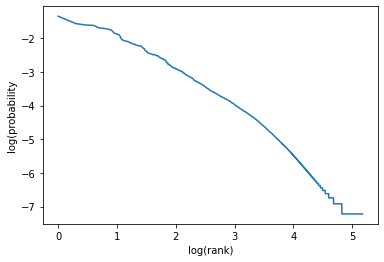

In [ ]:
# enter code here to plot the curve
import numpy

#rank
rank = list(range(1,totNumUniqueTermsIndexCount + 1))
logrank = numpy.log10(rank)


#probabiltiy 
res = dict(sorted(termProb.items(), key = itemgetter(1), reverse = True)[:totNumUniqueTermsIndexCount])
prob = []
for key in res:
  termprob = res[key]
  prob.append(numpy.log10(termprob))


import matplotlib.pyplot as plt
plt.plot(logrank, prob)
plt.xlabel("log(rank)")
plt.ylabel("log(probability")

